Imbalance ratio `p`:
	train:      n=320, p=0.618956
	test:       n=100, p=0.617284
	validation: n=80, p=0.615385
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  2304      
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  65792     
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  514       
Total params: 68,610
Trainable params: 68,610
Non-trainable params: 0
_________________________________________________________________
Sta

Training the DDQN:   3%|▎         | 500/16000 [00:00<00:09, 1634.87it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Training the DDQN: 100%|██████████| 16000/16000 [00:18<00:00, 879.78it/s]

:Time trained: 22.27
Best score: 0.797546!


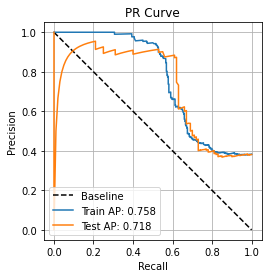

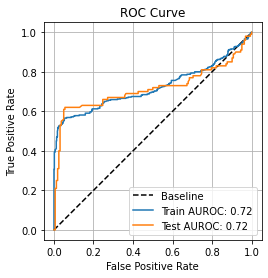

:Time evaluated: 0.3
{'Gmean': 0.802311, 'F1': 0.755981, 'Precision': 0.724771, 'Recall': 0.79, 'TP': 79, 'TN': 132, 'FP': 30, 'FN': 21}


In [4]:
import time
import os

import numpy as np
import tensorflow_datasets as tfds
from imbDRL.agents.ddqn import TrainDDQN
from imbDRL.data import get_train_test_val
from imbDRL.utils import rounded_dict
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # CPU is faster than GPU on structured data

episodes = 16_000  # Total number of episodes
warmup_steps = 16_000  # Amount of warmup steps to collect data with random policy
memory_length = warmup_steps  # Max length of the Replay Memory
batch_size = 32
collect_steps_per_episode = 500
collect_every = 500

target_update_period = 400  # Period to overwrite the target Q-network with the default Q-network
target_update_tau = 1  # Soften the target model update
n_step_update = 1

layers = [Dense(256, activation="relu"), Dropout(0.2),
          Dense(256, activation="relu"), Dropout(0.2),
          Dense(2, activation=None)]  # No activation, pure Q-values

learning_rate = 0.00025  # Learning rate
gamma = 0.0  # Discount factor
min_epsilon = 0.5  # Minimal and final chance of choosing random action
decay_episodes = episodes // 10  # Number of episodes to decay from 1.0 to `min_epsilon``

min_class = [1]  # Minority classes
maj_class = [0]  # Majority classes

df = tfds.as_dataframe(*tfds.load("titanic", split='train', with_info=True))
y = df.survived.values
df = df.drop(columns=["survived", "features/boat", "features/cabin", "features/home.dest", "features/name", "features/ticket"])
df = df.astype(np.float64)
df = (df - df.min()) / (df.max() - df.min())  # Normalization should happen after splitting train and test sets

X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), y, stratify=y, test_size=0.2)
X_train, y_train, X_test, y_test, X_val, y_val = get_train_test_val(X_train, y_train, X_test, y_test,
                                                                    min_class, maj_class, val_frac=0.2)

model = TrainDDQN(episodes, warmup_steps, learning_rate, gamma, min_epsilon, decay_episodes, target_update_period=target_update_period,
                  target_update_tau=target_update_tau, batch_size=batch_size, collect_steps_per_episode=collect_steps_per_episode,
                  memory_length=memory_length, collect_every=collect_every, n_step_update=n_step_update)

model.compile_model(X_train, y_train, layers)
model.q_net.summary()

print('Starting model training...')

time_start = time.time()
model.train(X_val, y_val, "F1")
print(f':Time trained: {round(time.time()-time_start,2)}')

time_start = time.time()
stats = model.evaluate(X_test, y_test, X_train, y_train)
print(f':Time evaluated: {round(time.time()-time_start,2)}')

print(rounded_dict(stats))


# {'Gmean': 0.824172, 'F1': 0.781395, 'Precision': 0.730435, 'Recall': 0.84, 'TP': 84, 'TN': 131, 'FP': 31, 'FN': 16}

In [22]:
df = tfds.as_dataframe(*tfds.load("titanic", split='train', with_info=True))
y = df.survived.values
df = df.drop(columns=["survived", "features/boat", "features/cabin", "features/home.dest", "features/name", "features/ticket"])
print(df['features/sex']) # Categorical variables need to be encoded first
df = df.astype(np.float64)
df = (df - df.min()) / (df.max() - df.min())  # Normalization should happen after splitting train and test sets

df

0       0
1       0
2       1
3       0
4       0
       ..
1304    0
1305    0
1306    1
1307    1
1308    0
Name: features/sex, Length: 1309, dtype: int64


,features/age,features/body,features/embarked,features/fare,features/parch,features/pclass,features/sex,features/sibsp
0,0.382716,0.000000,0.666667,0.027273,0.000000,0.5,0.0,0.000
1,0.469136,0.300912,0.666667,0.017387,0.000000,1.0,0.0,0.250
2,0.358025,0.000000,0.666667,0.027273,0.000000,0.5,1.0,0.000
3,0.234568,0.000000,0.666667,0.145131,0.000000,0.5,0.0,0.000
4,0.000000,0.000000,0.000000,0.017330,0.000000,1.0,0.0,0.000
...,...,...,...,...,...,...,...,...
1304,0.407407,0.000000,0.333333,0.017046,0.000000,1.0,0.0,0.000
1305,0.246914,0.000000,0.666667,0.017094,0.000000,1.0,0.0,0.000
1306,0.000000,0.000000,0.333333,0.017800,0.000000,1.0,1.0,0.000
1307,0.395062,0.000000,0.666667,0.041932,0.111111,1.0,1.0,0.125
